<a href="https://colab.research.google.com/github/bravoila/MachineLearning/blob/master/Evacuation_RL_0928_One_Class_126_90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rlcard

In [ ]:
pip install rlcard[tensorflow]

In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


Code for environment

In [ ]:
#from google.colab import files
#import io
#uploaded = files.upload()

In [ ]:
#import io
#io.BytesIO(uploaded['patient_generattion2.xlsx'])
#@title Code for Environment

In [ ]:
#@title Code for Environment
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 17 11:46:46 2020

@author: machaolun
"""
"""
Unit: Minute
"""
import gym
from gym import spaces

# import tkinter as tk
import random
import numpy as np
import pandas as pd
# from collections import deque
from heapq import heappush,heappop
import csv
import copy
from collections import deque

random.seed(2020)
# This class is to generate patients
total_simulation_time = 10000


def SURV_PROB_CAL(my_facility, my_patype, my_total_time, surv_num):
        # survival probablity
    # Resource-Based Patient Prioritization in Mass-Casualty Incidents
    # first is the worst case and the fifth is the optimistic case    
    # Immediate         Delayed
    # β0,I β1,I β2,I    β0,D β1,D β2,D
    # 0.09,17  ,1.01    0.57,61   ,2.03
    # 0.15,28  ,1.38    0.65,86   ,2.11
    # 0.24,47  ,1.30    0.76,138  ,2.17
    # 0.40,59  ,1.47    0.77,140  ,2.29
    # 0.56,91  ,1.58    0.81,160  ,1.41
    if surv_num == 1:
        # set para
        # Senerio 1, assume no different between ACF and hospital
        if my_facility == 1 and my_patype == 0:
            """Hospital, immediate"""
            Beta = [0.09,17  ,1.01]
        elif my_facility == 1 and my_patype == 1:
            """Hospital, delayed"""
            Beta = [0.57,61 ,2.03]
        elif my_facility == 2 and my_patype == 0:
            """ACF, immediate"""
            Beta = [0.09,17  ,1.01]
        elif my_facility == 2 and my_patype == 1:
            """ACF, delayed"""
            Beta = [0.57,61   ,2.03]
    elif surv_num == 2:       
        # # Senerio 2, assume no different between ACF and hospital
        if my_facility == 1 and my_patype == 0:
            """Hospital, immediate"""
            Beta = [0.15,28  ,1.38]
        elif my_facility == 1 and my_patype == 1:
            """Hospital, delayed"""
            Beta = [0.65,86   ,2.11]
        elif my_facility == 2 and my_patype == 0:
            """ACF, immediate"""
            Beta = [0.15,28  ,1.38]
        elif my_facility == 2 and my_patype == 1:
            """ACF, delayed"""
            Beta = [0.65,86   ,2.11]
            
    elif surv_num == 3:
        
        # # Senerio 3, assume no different between ACF and hospital
        if my_facility == 1 and my_patype == 0:
            """Hospital, immediate"""
            Beta = [0.24,47  ,1.30]
        elif my_facility == 1 and my_patype == 1:
            """Hospital, delayed"""
            Beta = [0.76,138  ,2.17]
        elif my_facility == 2 and my_patype == 0:
            """ACF, immediate"""
            Beta = [0.24,47  ,1.30]
        elif my_facility == 2 and my_patype == 1:
            """ACF, delayed"""
            Beta = [0.76,138  ,2.17]
    elif surv_num == 4:
            
        # # Senerio 4, assume no different between ACF and hospital
        if my_facility == 1 and my_patype == 0:
            """Hospital, immediate"""
            Beta = [0.40,59  ,1.47]
        elif my_facility == 1 and my_patype == 1:
            """Hospital, delayed"""
            Beta = [0.77,140  ,2.29]
        elif my_facility == 2 and my_patype == 0:
            """ACF, immediate"""
            Beta = [0.40,59  ,1.47]
        elif my_facility == 2 and my_patype == 1:
            """ACF, delayed"""
            Beta = [0.77,140  ,2.29]            
    elif surv_num == 5:
        # Senerio 5, assume no different between ACF and hospital            
        if my_facility == 1 and my_patype == 0:
            """Hospital, immediate"""
            Beta = [0.56,91  ,1.58]
        elif my_facility == 1 and my_patype == 1:
            """Hospital, delayed"""
            Beta = [0.81,160  ,1.41]
        elif my_facility == 2 and my_patype == 0:
            """ACF, immediate"""
            Beta = [0.56,91  ,1.58]
        elif my_facility == 2 and my_patype == 1:
            """ACF, delayed"""
            Beta = [0.81,160  ,1.41]        
    
    # 0.9 is ACF discount factor
    if my_facility == 1:
        SP = Beta[0]/((my_total_time/Beta[1]) ** Beta[2] + 1.0)
    else:
        SP = 0.8 * Beta[0]/((my_total_time/Beta[1]) ** Beta[2] + 1.0)
    return SP


def eva_perform(env, num):
    ''' Evaluate he performance of the agents in the environment
    Args:
        env (Env class): The environment to be evaluated.
        num (int): The number of games to play.
    Returns:
        A list of avrage payoffs for each player
    '''
    payoffs = 0
    counter = 0

    while counter < num:
        tj = env.run(1, is_training=False)
        return_ = pd.DataFrame(tj)
        payoffs += sum(return_[2])
        counter += 1

    payoffs /= counter
    
    return payoffs

class Event(object):
    # num_of_events = 0
    def __init__(self,generate_time, ptype, surv_num):
        self.generate_time = generate_time
        self.trans_time = 0.2
        self.arrival_time = 0.3
        self.start_service_time = 0.4
        self.service_time = 0.5
        self.departure_time = 0.6
        self.survival_prob_res = 0
        self.facility = 0.7
        self.patype = ptype
        self.status = "default"
        self.surv_num = surv_num
        # severe , minor
        # Event.num_of_events += 1
    def total_time(self):
        return self.departure_time - self.generate_time
    
    def sojourn_time(self):
        return self.departure_time - self.arrival_time

    def waiting_time(self):
        # waiting time in queue
        return self.sojourn_time() - self.service_time
    
    def survival_prob(self):
        my_total_time = self.total_time()
        SP = SURV_PROB_CAL(self.facility, self.patype, my_total_time, self.surv_num)
        self.survival_prob_res = SP
        return SP

    def __repr__(self):
        return f"{self.generate_time}, {self.trans_time},{self.arrival_time}, {self.start_service_time}, {self.service_time}, {self.departure_time}, {self.survival_prob_res}, {self.facility}, {self.patype} \n"
    def get_info(self):
        #print([self.generate_time, self.trans_time, self.arrival_time, self.start_service_time, self.service_time, self.departure_time, self.facility, self.patype, self.status])
        return [self.generate_time, self.trans_time, self.arrival_time, self.start_service_time, self.service_time, self.departure_time, self.survival_prob_res, self.facility, self.patype, self.status]
    
"""########################################################################"""

class Server(object):
    def __init__(self, c, status, mu0, mu1, tt):
        # self.jobs = jobs
        self.c = c
        self.status = status
        self.mu0 = mu0
        self.mu1 = mu1
        self.tt = tt
        self.server_tnext = 0

        self.num_busy = 0  # number of busy servers
        self.stack = []    # store the patient info in the server
        self.queue = []
        self.served_jobs = [] 

    def handle_arrival(self, time, job):
        # time here refers to arrival time
        # print("arrival_job", job)
        # input("arrival")
    
        if self.num_busy < self.c:
            if len(self.queue) == 0:
                # print("handle_arrival1 ")
                self.start_service(time, job)
        else:
            job.status = "queue"
            heappush(self.queue, ((job.patype, job.arrival_time), job))
            
        # print("handle_arrival_done ")

    def start_service(self, time, job):
        # time here refers to start service time
        self.num_busy += 1  # server becomes busy.
        job.start_service_time = time
        job.departure_time = time + job.service_time
        
        job.status = "stack"
        heappush(self.stack, (job.departure_time, job))
        
        # print("service_job ", job)
        # input("service")
        
        if job.departure_time <= self.server_tnext:
            # print("start_service1 ")
            self.handle_departure()
            
        
    def handle_departure(self):
        # time here refers to departure time 
        # self.stack.sort(reverse=True)
        try:
            while self.stack[0][0] <= self.server_tnext:
                # print("while ", self.stack[0][0], self.server_tnext)
                prev_depart = copy.deepcopy(self.stack[0][0])
                self.num_busy -= 1
                self.stack[0][1].status = "released"
                next_done = heappop(self.stack)
                next_done[1].survival_prob()
                self.served_jobs.append(next_done)
                
                # print("next_done ",next_done)
                # input("depature")
                
                if self.queue and self.num_busy < self.c:
                    if self.queue[0][1].arrival_time < self.server_tnext:
                        # print("queue")
                        # print("self.server_tnext ", self.server_tnext)
                        # print("prev_depart ", prev_depart)
                        next_job = heappop(self.queue)
                        # print("next_job! ", next_job)
                        
                        # input("here1")
                        # print("arr!", next_job[1].arrival_time)
                        # print("prev!",prev_depart)
                        # input("here2")
                        self.start_service(max(next_job[1].arrival_time, prev_depart),next_job[1])
        except:
            pass
        
    def travel_time(self):
        return self.tt
        # return random.expovariate(self.tt)
        
        # return self.tt
        
    def service_time(self, patient_type):
        if patient_type == 0:
            return random.expovariate(self.mu0)
        else:
            return random.expovariate(self.mu1)
            
    def getSize(self, tnow):
        try:
            count_queue0 = 0
            count_queue1 = 0
            copy_queue = copy.deepcopy(self.queue)
            for item in copy_queue:
                if item[1].arrival_time <= tnow: 
                    if item[1].patype == 0:
                        count_queue0 += 1
                    else:
                        count_queue1 += 1      
                    
            return [count_queue0, count_queue1]
        
        except:
            return [0,0]
    
    
    """need to optimize code """
    def getBusyServer(self, tnow):
        count_busyserver = 0
        copy_stack = copy.deepcopy(self.stack) + copy.deepcopy(self.served_jobs) 
        # print("copy_stack ", copy_stack)
        # print("stack ", self.stack
        
        try:
            for item in copy_stack:
                # print("item ",item[1])
                if item[1].departure_time >= tnow and item[1].start_service_time <= tnow and count_busyserver < self.c:
                    count_busyserver += 1
                # print("count_busyserver", count_busyserver)
                
            return [count_busyserver]
        
        except:
            return [0]
    
    
"""########################################################################"""

def AssignType():
    # set para
    p = 0
    myassign = np.random.binomial(1,p)
    if myassign == 1:
        patype = 0
    else:
        patype = 1
    
    return patype

"""########################################################################"""

class Env(gym.Env):
    def __init__(self, tnow):
        self.tnow = tnow
        self.gen_patient_time_list = []
        self.tgen = 0
        self.tgen_next = 0
        self.arrival_list1 = []
        self.arrival_list2 = []
        self.arrival_time = self.tnow
        self.surv_num = 5
        # Define constants for clearer code
        self.S1 = 0
        self.S2 = 1
        self.action_num = 2
        self.action_space = spaces.Discrete(self.action_num)

        
        """['gen_time', 'num_to_hos', 'num_to_acf', 
        'ql10' ,'ql11', 'ql20', 'ql21', 'busy_1', 'busy_2','served_1', 'served_2', 'rewards'])"""    
        """ obs space"""
        """ ['num_to_hos', 'num_to_acf', 'ql10' ,'ql11', 'ql20', 'ql21', 'busy_1', 'busy_2', 
        'waiting time at hos', ' service at hos', 'waiting time at acf', ' service at acf'])"""
        
        self.obs_low = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        self.obs_high = np.array([15, 15, 20, 20, 20, 20, 8, 4, 1000, 1000, 1000, 1000])
        # self.observation_space = spaces.Box(self.obs_low, self.obs_high, dtype=np.int32)
        
        self.tgen_list = []
        # pd.DataFrame(columns = ['gen_time', 'num_to_hos', 'num_to_acf', 
        # 'ql10' ,'ql11', 'ql20', 'ql21', 'busy_1', 'busy_2','served_1', 'served_2', 'rewards'])
        self.rewards_records = {}
        self.obs_records = {}
        self.action_records = {}
        self.wait_records1 = {}  # queuing_time
        self.service_records1 = {} #service_time
        self.wait_records2 = {}  # queuing_time
        self.service_records2 = {}

        """Server Settings"""
        """ mu_tt = log(x) """
        """pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))"""

        # set para server

        self.server1_rate0 = 1/90  
        self.server1_rate1 = 1/30
        """ mean value, not mu"""
        self.server1_tt = 90
        
        self.server2_rate0 = 1/90
        self.server2_rate1 = 1/30
        
        """ mean value, not mu"""
        self.server2_tt = 10
        
        # __init__(self, c, status, mu0, mu1, tt):
        self.server1 = Server(12, 'open',self.server1_rate0,self.server1_rate1,self.server1_tt)
        self.server2 = Server(6, 'open', self.server2_rate0, self.server2_rate1,self.server2_tt)
        self.s2_isopen = True   
        self.simulation_time = total_simulation_time
        
        
    #     """ use pre-generated data"""
    # def Get_Time(self, myi):
    #     nlength = 50
    #     a = pd.read_excel("/Users/machaolun/Documents/GitHub/EvacuationMDP/Evacuation_code/RL/patient_generattion2.xlsx",
    #               index_col=0)
    #     b = list(a.iloc[myi,:nlength])
    #     self.gen_patient_time_list = deque(b)
        
        
        """ use generated data"""
    def Get_Time(self, myi):
        total_num_patient = 50
        arrive_lambda = 1/5.0
        mylist = []
        t= 0
        """Generate Casulties"""
        for j in range(total_num_patient):
            t+= random.expovariate(arrive_lambda)
            mylist.append(t)   
            
        self.gen_patient_time_list = deque(mylist)   
    # def GenerateTime(self):
    #     """
    #     Arrival rate per min
    #     Set Arrival Rate (time inhomogeneous) Here
    #     """
    #     # ref: https://zhuanlan.zhihu.com/p/28785318
    #     t = 0
    #     I = 0
    #     s = []
        
    #     max_simulate_time = 1000
        
    #     while t <= max_simulate_time:
    #         u = np.random.uniform(1e-8,1)
    #         t = t - np.log(u)
    #         if t <= max_simulate_time:
    #             u1 = np.random.uniform(1e-8,1)
    #             if u1 <= inhop(t):
    #                 I = I + 1
    #                 s.append(t)
                    
    #     # time when event happens
    #     self.gen_patient_time_list = deque(s)        
    
    """ Open new ACF, the resource comes from hospital"""        
    # def take_action(self, Action):
    #     if (not self.s2_isopen) and Action == "open":
    #         original_num_server = copy.deepcopy(self.server1.c)
    #         self.s2_isopen = True
            
    #         # set para
    #         precent_move = 0.2
    #         self.server1.c = round((1 - precent_move)*original_num_server)
    #         self.server2.c = int(precent_move * original_num_server) + 2 
    #         self.server2.status = 'open'
            
    #         print("!!!!!!!!!!!!!!!\n",self.server1.c, self.server2.c)
    #     else:
    #         pass 
        
    def step(self, Action):
        
        try:
            self.tgen = self.gen_patient_time_list.popleft()
            try:
                self.tgen_next = self.gen_patient_time_list[0]
            except:
                self.tgen_next = 100000
            # action records
            self.action_records[self.tgen] = Action
            
            patient = Event(self.tgen, AssignType(), self.surv_num)

            #  self.s2_isopen and         
            if Action == self.S2:    
                patient.trans_time = self.server2.travel_time()
                # self.server2.tnext = min(self.tgen + patient.travel_time , self.simulation_time)
                patient.facility = 2
                patient.arrival_time = patient.generate_time + patient.trans_time
                patient.service_time = self.server2.service_time(patient.patype)
                heappush(self.arrival_list2, ((patient.arrival_time), patient))
                
            elif Action == self.S1:
                patient.trans_time = self.server1.travel_time()
                # self.server1.tnext = min(self.tgen + patient.travel_time, self.simulation_time)
                patient.facility = 1
                patient.arrival_time = patient.generate_time + patient.trans_time
                patient.service_time = self.server1.service_time(patient.patype) 
                heappush(self.arrival_list1, ((patient.arrival_time), patient))
                                
            else:
                raise ValueError("Received invalid action={} which is not part of the action space".format(Action))
        
        except:
            self.tgen_next = 100001
            
        try:
            while self.arrival_list1[0][0] <= self.tgen_next:
                try:
                    self.server1.server_tnext = min(self.arrival_list1[0][0], self.tgen_next)
                except:
                    self.server1.server_tnext = self.tgen_next
                    
                self.server1.handle_departure()
                mypatient_s1 = heappop(self.arrival_list1)
                self.server1.handle_arrival(mypatient_s1[1].arrival_time, mypatient_s1[1])
                
        except:
            pass
        
        self.server1.server_tnext = self.tgen_next    
        self.server1.handle_departure()
        
        if self.s2_isopen:
            try:
                while self.arrival_list2[0][0] <= self.tgen_next:
    
                    try:
                        self.server2.server_tnext = min(self.arrival_list2[0][0], self.tgen_next)
                    except:
                        self.server2.server_tnext = self.tgen_next
                        
                    self.server2.handle_departure()
                    
                    mypatient_s2 = heappop(self.arrival_list2)
                    self.server2.handle_arrival(mypatient_s2[1].arrival_time, mypatient_s2[1])
                    
            except:
                pass
            
            self.server2.server_tnext = self.tgen_next
            self.server2.handle_departure()
                
        """ gen_time, num to hos, num to acf, 
        [ql10,ql11], [ql20, ql21],
        busy server1, busy 2 """        
        """['gen_time', 'num_to_hos', 'num_to_acf', 
        'ql10' ,'ql11', 'ql20', 'ql21', 'busy_1', 'busy_2','served_1', 'served_2', 'rewards'])"""    
        
        # print("self.tgen_next", self.tgen_next)
        if self.s2_isopen:
            Legal_Action = [0,1]
        else:
            Legal_Action = [0,1]

        # for the first one
        if len(self.gen_patient_time_list) == 49:
            self.tgen_list.append([self.tgen, Legal_Action])
            self.obs_records[self.tgen] = np.array([self.tgen, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0 ]) 

            #action record is above 
            
        all_served = self.server1.served_jobs + self.server2.served_jobs
        
       
        for jobs in all_served:
            self.rewards_records[jobs[1].generate_time] = jobs[1].survival_prob_res
  
        # add obs to records
        if self.tgen_next < 100000:
            self.tgen_list.append([self.tgen_next, Legal_Action])
            i = 0
            j = 0
            w_record1 = 0
            s_record1 = 0
            w_record2 = 0
            s_record2 = 0
            
            for jobs2 in all_served:

                # time window -- future consideration
                if jobs2[1].departure_time < self.tgen_next and jobs2[1].facility  == 1: # 1hos 2acf
                    i += 1
                    w_record1 += jobs2[1].waiting_time()            
                    s_record1 += jobs2[1].service_time
                    
                if jobs2[1].departure_time < self.tgen_next and jobs2[1].facility  == 2: # 1hos 2acf
                    j += 1
                    w_record2 += jobs2[1].waiting_time()            
                    s_record2 += jobs2[1].service_time                    

            self.wait_records1[self.tgen_next] = 0 if i == 0 else int(round(w_record1/i))   # queuing_time
            self.service_records1[self.tgen_next] = 0 if i == 0 else int(round(s_record1/i)) #service_time

            self.wait_records2[self.tgen_next] = 0 if j == 0 else int(round(w_record2/j))   # queuing_time
            self.service_records2[self.tgen_next] = 0 if j == 0 else int(round(s_record2/j))  #service_time
                   
            # observation records
            self.obs_records[self.tgen_next] = np.array([self.tgen_next, len(self.arrival_list1), len(self.arrival_list2)] 
                        + self.server1.getSize(self.tgen_next)
                        + self.server2.getSize(self.tgen_next)
                        + self.server1.getBusyServer(self.tgen_next)
                        + self.server2.getBusyServer(self.tgen_next)
                        + [self.wait_records1[self.tgen_next],
                           self.service_records1[self.tgen_next],
                           self.wait_records2[self.tgen_next],
                           self.service_records2[self.tgen_next]])
                                                        
                        # + [len(self.server1.served_jobs)]
                        # + [len(self.server2.served_jobs)])
            states = {'obs': np.delete(self.obs_records[self.tgen_next],0), 
                      'legal_actions': Legal_Action}
        else:
            states = {'obs': self.obs_low,
                      'legal_actions': [0,1]}
        

            
             
        returns = []

        for everyone in self.tgen_list[:]:
            try:
                rewards = self.rewards_records[everyone[0]]
                
                obs = self.obs_records[everyone[0]]
                
                actions = self.action_records[everyone[0]]
                
                returns.append({'obs': obs,'legal_actions': everyone[1],'action': actions ,'reward': rewards})
                self.tgen_list.remove(everyone)
            except:
                continue

        done = bool(self.tgen_next == 100000)
        # obs = np.array([1,1,1,1,1,1,1,1])
        # reward = 1
        info = {}
        
        return states, returns, done, info
        
    def set_agents(self, agents):
        ''' Set the agents that will interact with the environment
        Args:
            agents (list): List of Agent classes
        '''
        self.agents = agents


    def run(self, myj, is_training=False):
        '''
        Run a complete game, either for evaluation or training RL agent.
        Args:
            is_training (boolean): True if for training purpose.
        Returns:
            (tuple) Tuple containing:
                (list): A list of trajectories generated from the environment.
                (list): A list payoffs. Each entry corresponds to one player.
        Note: The trajectories are 3-dimension list. The first dimension is for different players.
              The second dimension is for different transitions. The third dimension is for the contents of each transiton
        '''
        return_summary = []
        done = False
        
        states, returns, done, info = self.reset()
        # read arrival data 
        self.Get_Time(myj)
        
        while not done:
            # action, _states = model.predict(states)
            if not is_training:
                action, probs_ = self.agents.eval_step(states)
                # print("best action ", action)
                # print("probs ", probs_)
            else:
                action = self.agents.step(states)
            
            # if random.random() > 0.9:
            #     action = 1   
            # else:
            #     action = 0
            # action = 0
            
            states, returns, done, info = self.step(action)
            
            return_summary = np.append(return_summary, returns)
        
        # served_result = self.get_stat()
        
        # print(served_result)
        
        list2 = [x for x in return_summary if x != []]
        sorted_ts = sorted(list2, key = lambda i: i['obs'][0]) 
        
        trajectories = []

        for i in range(len(sorted_ts) - 1):
            #np.delete(sorted_ts[i]['obs'],0)
            trajectories.append([{'obs': np.delete(sorted_ts[i]['obs'],0), 'legal_actions': sorted_ts[i]['legal_actions']}, sorted_ts[i]['action'],sorted_ts[i]['reward'],
          {'obs': np.delete(sorted_ts[i+1]['obs'],0), 'legal_actions': sorted_ts[i+1]['legal_actions']}, bool(i == len(sorted_ts) - 2)])
        
        return trajectories
    
    def get_Reward(self):
    # Playing Atari with Deep Reinforcement Learning    
    # receives a reward rt representing the change in game score.
    # survival probablity
    # Resource-Based Patient Prioritization in Mass-Casualty Incidents
        all_served = self.server1.served_jobs + self.server2.served_jobs
        
        for jobs in all_served:
            # if jobs[1].generate_time not in list(self.rewards_records.keys()):
            self.rewards_records[jobs[1].generate_time] = jobs[1].survival_prob_res


    def reset(self):
        # return observation
        self.tnow = 0
        self.gen_patient_time_list = []
        self.tgen = 0
        self.tnext = 0
        self.arrival_list1 = []
        self.arrival_list2 = []
        self.arrival_time = self.tnow
        self.surv_num = 5

        
        """['gen_time', 'num_to_hos', 'num_to_acf', 
        'ql10' ,'ql11', 'ql20', 'ql21', 'busy_1', 'busy_2','served_1', 'served_2', 'rewards'])"""    
        """ obs space"""
        """ ['num_to_hos', 'num_to_acf', 'ql10' ,'ql11', 'ql20', 'ql21', 'busy_1', 'busy_2', 'waiting time ', ' service'])"""
        
        # self.observation_space = spaces.Box(self.obs_low, self.obs_high, dtype=np.int32)
        
        self.tgen_list = []
        # pd.DataFrame(columns = ['gen_time', 'num_to_hos', 'num_to_acf', 
        # 'ql10' ,'ql11', 'ql20', 'ql21', 'busy_1', 'busy_2','served_1', 'served_2', 'rewards'])
        self.rewards_records = {}
        self.obs_records = {}
        self.action_records = {}
        self.wait_records1 = {}  # queuing_time
        self.service_records1 = {} #service_time
        self.wait_records2 = {}  # queuing_time
        self.service_records2 = {}
        
        
        self.server1 = Server(12, 'open',self.server1_rate0,self.server1_rate1,self.server1_tt)
        self.server2 = Server(6, 'not_open', self.server2_rate0, self.server2_rate1,self.server2_tt)
        self.s2_isopen = True
        self.simulation_time = 100000
        
        done = False
        info = {}
        returns = []
        states = {'obs': self.obs_low,'legal_actions': [0,1]}
        
        return states, returns, done, info

    
    def get_stat(self):
        # Avg_SojournTime, Avg_WaitingTime, Avg_QueueLength
        SojournTime1 = 0.0
        WaitingTime1 = 0.0
        SojournTime2 = 0.0
        WaitingTime2 = 0.0
        
        mydata = []
        
        for jobs in self.server1.served_jobs:
            SojournTime1 += jobs[1].sojourn_time()
            WaitingTime1 += jobs[1].waiting_time()
            """ f"{self.arrival_time}, {self.start_service_time}, {self.service_time}, 
            {self.departure_time}, {self.facility}, {self.patype} \n" """

            # heappush(mydata, (jobs[1].arrival_time, jobs[1].get_info()))
            mydata.append(jobs[1].get_info())
            
            """also attach patient in queue and not release"""
            
        for not_complete_job in self.server1.stack:
            mydata.append(not_complete_job[1].get_info())
            
        for not_complete_job in self.server1.queue:
            mydata.append(not_complete_job[1].get_info())

        with open('Server1.csv', 'w', newline='') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerows(mydata)        
        
        mydata = []
        
        for jobs in self.server2.served_jobs:
            SojournTime2 += jobs[1].sojourn_time()
            WaitingTime2 += jobs[1].waiting_time()
            mydata.append(jobs[1].get_info())
            # mydata.append([jobs[1].arrival_time,jobs[1].start_service_time,jobs[1].service_time, jobs[1].departure_time])
            # print("{0:.8f}".format(jobs[1].arrival_time), "{0:.8f}".format(jobs[1].start_service_time),\
            #       "{0:.8f}".format(jobs[1].service_time), "{0:.8f}".format(jobs[1].departure_time))
            # print(jobs[1].get_info())
            
        for not_complete_job in self.server2.stack:
            mydata.append(not_complete_job[1].get_info())
            
        for not_complete_job in self.server2.queue:
            mydata.append(not_complete_job[1].get_info())            
        
        with open('Server2.csv', 'w', newline='') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerows(mydata) 
            
            
        if len(self.server1.served_jobs) != 0:
            Avg_SojournTime1 = SojournTime1/len(self.server1.served_jobs)
            Avg_WaitingTime1 = WaitingTime1/len(self.server1.served_jobs)
        else:    
            Avg_SojournTime1 = None
            Avg_WaitingTime1 = None

        if len(self.server2.served_jobs) != 0:
            Avg_SojournTime2 = SojournTime2/len(self.server2.served_jobs)             
            Avg_WaitingTime2 = WaitingTime2/len(self.server2.served_jobs)
        else:
            Avg_SojournTime2 = None
            Avg_WaitingTime2 = None
            
        
        return  Avg_SojournTime1, Avg_WaitingTime1, \
            Avg_SojournTime2, Avg_WaitingTime2
                # Avg_QueueLength1, Avg_QueueLength2
        
    def debug(self):
        print("==============")
        # self.server1.queue,
        # print("server1  ", self.server1.c, self.server1.action, \
              # self.server1.getSize(),  self.server1.stack)
        # print("served job ", self.server1.served_jobs)
        # print("server2  ", self.server2.c, self.server2.action, \
        # self.server2.getSize(), self.server2.stack)


 


In [ ]:
import tensorflow as tf
import os
import pandas as pd
import rlcard

from rlcard.utils import set_global_seed
from rlcard.utils import Logger

In [ ]:
#@title Code for Agent
''' DQN agent
The code is derived from https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/dqn.py
Copyright (c) 2019 DATA Lab at Texas A&M University
Copyright (c) 2016 Denny Britz
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

import random
import numpy as np
import tensorflow as tf
from collections import namedtuple

from rlcard.utils.utils import remove_illegal

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])


class DQNAgent(object):

    def __init__(self,
                 sess,
                 scope,
                 replay_memory_size=10000,
                 replay_memory_init_size=200,
                 update_target_estimator_every=1000,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=10000,
                 batch_size=32,
                 action_num=2,
                 state_shape=None,
                 train_every=1,
                 mlp_layers=None,
                 learning_rate=0.00005):

        '''
        Q-Learning algorithm for off-policy TD control using Function Approximation.
        Finds the optimal greedy policy while following an epsilon-greedy policy.
        Args:
            sess (tf.Session): Tensorflow Session object.
            scope (string): The name scope of the DQN agent.
            replay_memory_size (int): Size of the replay memory
            replay_memory_init_size (int): Number of random experiences to sampel when initializing
              the reply memory.
            train_every (int): Train the agent every X steps.
            update_target_estimator_every (int): Copy parameters from the Q estimator to the
              target estimator every N steps
            discount_factor (float): Gamma discount factor
            epsilon_start (int): Chance to sample a random action when taking an action.
              Epsilon is decayed over time and this is the start value
            epsilon_end (int): The final minimum value of epsilon after decaying is done
            epsilon_decay_steps (int): Number of steps to decay epsilon over
            batch_size (int): Size of batches to sample from the replay memory
            evaluate_every (int): Evaluate every N steps
            action_num (int): The number of the actions
            state_space (list): The space of the state vector
            train_every (int): Train the network every X steps.
            mlp_layers (list): The layer number and the dimension of each layer in MLP
            learning_rate (float): The learning rate of the DQN agent.
        '''
        self.use_raw = False
        self.sess = sess
        self.scope = scope
        self.replay_memory_init_size = replay_memory_init_size
        self.update_target_estimator_every = update_target_estimator_every
        self.discount_factor = discount_factor
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.action_num = action_num
        self.train_every = train_every

        # Total timesteps
        self.total_t = 0

        # Total training step
        self.train_t = 0

        # The epsilon decay scheduler
        self.epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

        # Create estimators
        self.q_estimator = Estimator(scope=self.scope+"_q", action_num=action_num, learning_rate=learning_rate, state_shape=state_shape, mlp_layers=mlp_layers)
        self.target_estimator = Estimator(scope=self.scope+"_target_q", action_num=action_num, learning_rate=learning_rate, state_shape=state_shape, mlp_layers=mlp_layers)

        # Create replay memory
        self.memory = Memory(replay_memory_size, batch_size)

    def feed(self, ts):
        ''' Store data in to replay buffer and train the agent. There are two stages.
            In stage 1, populate the memory without training
            In stage 2, train the agent every several timesteps
        Args:
            ts (list): a list of 5 elements that represent the transition
        '''
        (state, action, reward, next_state, done) = tuple(ts)
        self.feed_memory(state['obs'], action, reward, next_state['obs'], done)
        self.total_t += 1
        tmp = self.total_t - self.replay_memory_init_size
        if tmp>=0 and tmp%self.train_every == 0:
            self.train()

    def step(self, state):
        ''' Predict the action for generating training data
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
        '''
        A = self.predict(state['obs'])
        A = remove_illegal(A, state['legal_actions'])
        action = np.random.choice(np.arange(len(A)), p=A)
        return action

    def eval_step(self, state):
        ''' Predict the action for evaluation purpose.
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
            probs (list): a list of probabilies
        '''
        q_values = self.q_estimator.predict(self.sess, np.expand_dims(state['obs'], 0))[0]
        probs = remove_illegal(np.exp(q_values), state['legal_actions'])
        best_action = np.argmax(probs)

        # print("q_values ", q_values)
        # print("eval_step ", state, best_action, probs)
        return best_action, probs

    def predict(self, state):
        ''' Predict the action probabilities
        Args:
            state (numpy.array): current state
        Returns:
            q_values (numpy.array): a 1-d array where each entry represents a Q value
        '''
        epsilon = self.epsilons[min(self.total_t, self.epsilon_decay_steps-1)]
        A = np.ones(self.action_num, dtype=float) * epsilon / self.action_num
        q_values = self.q_estimator.predict(self.sess, np.expand_dims(state, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A

    def train(self):
        ''' Train the network
        Returns:
            loss (float): The loss of the current batch.
        '''
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample()
        # Calculate q values and targets (Double DQN)
        q_values_next = self.q_estimator.predict(self.sess, next_state_batch)
        best_actions = np.argmax(q_values_next, axis=1)
        q_values_next_target = self.target_estimator.predict(self.sess, next_state_batch)
        target_batch = reward_batch + np.invert(done_batch).astype(np.float32) * \
            self.discount_factor * q_values_next_target[np.arange(self.batch_size), best_actions]

        # Perform gradient descent update
        state_batch = np.array(state_batch)
        loss = self.q_estimator.update(self.sess, state_batch, action_batch, target_batch)
        print('\rINFO - Agent {}, step {}, rl-loss: {}'.format(self.scope, self.total_t, loss), end='')


        # Update the target estimator
        if self.train_t % self.update_target_estimator_every == 0:
            copy_model_parameters(self.sess, self.q_estimator, self.target_estimator)
            print("\nINFO - Copied model parameters to target network.")

        self.train_t += 1

    def feed_memory(self, state, action, reward, next_state, done):
        ''' Feed transition to memory
        Args:
            state (numpy.array): the current state
            action (int): the performed action ID
            reward (float): the reward received
            next_state (numpy.array): the next state after performing the action
            done (boolean): whether the episode is finished
        '''
        self.memory.save(state, action, reward, next_state, done)

    def copy_params_op(self, global_vars):
        ''' Copys the variables of two estimator to others.
        Args:
            global_vars (list): A list of tensor
        '''
        self_vars = tf.contrib.slim.get_variables(scope=self.scope, collection=tf.GraphKeys.TRAINABLE_VARIABLES)
        update_ops = []
        for v1, v2 in zip(global_vars, self_vars):
            op = v2.assign(v1)
            update_ops.append(op)
        self.sess.run(update_ops)

class Estimator():
    ''' Q-Value Estimator neural network.
        This network is used for both the Q-Network and the Target Network.
    '''

    def __init__(self, scope="estimator", action_num=2, learning_rate=0.001, state_shape=None, mlp_layers=None):
        ''' Initilalize an Estimator object.
        Args:
            action_num (int): the number output actions
            state_shap (list): the shape of the state space
        '''
        self.scope = scope
        self.action_num = action_num
        self.learning_rate=learning_rate
        self.state_shape = state_shape if isinstance(state_shape, list) else [state_shape]
        self.mlp_layers = map(int, mlp_layers)

        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=tf.get_variable_scope().name)
        # Optimizer Parameters from original paper
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, name='dqn_adam')

        with tf.control_dependencies(update_ops):
            self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

    def _build_model(self):
        ''' Build an MLP model.
        '''
        # Placeholders for our input
        # Our input are 4 RGB frames of shape 160, 160 each
        input_shape = [None]
        input_shape.extend(self.state_shape)
        self.X_pl = tf.placeholder(shape=input_shape, dtype=tf.float32, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")
        # Boolean to indicate whether is training or not
        self.is_train = tf.placeholder(tf.bool, name="is_train")

        batch_size = tf.shape(self.X_pl)[0]

        # Batch Normalization
        X = tf.layers.batch_normalization(self.X_pl, training=self.is_train)

        # Fully connected layers
        fc = tf.contrib.layers.flatten(X)
        for dim in self.mlp_layers:
            fc = tf.contrib.layers.fully_connected(fc, dim, activation_fn=tf.tanh)
        self.predictions = tf.contrib.layers.fully_connected(fc, self.action_num, activation_fn=None)

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calculate the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

    def predict(self, sess, s):
        ''' Predicts action values.
        Args:
          sess (tf.Session): Tensorflow Session object
          s (numpy.array): State input of shape [batch_size, 4, 160, 160, 3]
          is_train (boolean): True if is training
        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated
          action values.
        '''
        return sess.run(self.predictions, { self.X_pl: s, self.is_train:False})

    def update(self, sess, s, a, y):
        ''' Updates the estimator towards the given targets.
        Args:
          sess (tf.Session): Tensorflow Session object
          s (list): State input of shape [batch_size, 4, 160, 160, 3]
          a (list): Chosen actions of shape [batch_size]
          y (list): Targets of shape [batch_size]
        Returns:
          The calculated loss on the batch.
        '''
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a, self.is_train: True}
        _, _, loss = sess.run(
                [tf.contrib.framework.get_global_step(), self.train_op, self.loss],
                feed_dict)
        return loss

class Memory(object):
    ''' Memory for saving transitions
    '''

    def __init__(self, memory_size, batch_size):
        ''' Initialize
        Args:
            memory_size (int): the size of the memroy buffer
        '''
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = []

    def save(self, state, action, reward, next_state, done):
        ''' Save transition into memory
        Args:
            state (numpy.array): the current state
            action (int): the performed action ID
            reward (float): the reward received
            next_state (numpy.array): the next state after performing the action
            done (boolean): whether the episode is finished
        '''
        if len(self.memory) == self.memory_size:
            self.memory.pop(0)
        transition = Transition(state, action, reward, next_state, done)
        self.memory.append(transition)

    def sample(self):
        ''' Sample a minibatch from the replay memory
        Returns:
            state_batch (list): a batch of states
            action_batch (list): a batch of actions
            reward_batch (list): a batch of rewards
            next_state_batch (list): a batch of states
            done_batch (list): a batch of dones
        '''
        samples = random.sample(self.memory, self.batch_size)
        return map(np.array, zip(*samples))

def copy_model_parameters(sess, estimator1, estimator2):
    ''' Copys the model parameters of one estimator to another.
    Args:
        sess (tf.Session): Tensorflow Session object
        estimator1 (Estimator): Estimator to copy the paramters from
        estimator2 (Estimator): Estimator to copy the parameters to
    '''
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)

    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)

    sess.run(update_ops)

#if __name__ == "__main__":
#    with tf.Session() as sess:
#        agent = DQNAgent(sess,
#                         scope='dqn',
#                         action_num=4,
#                         replay_memory_init_size=100,
#                         norm_step=100,
#                         state_shape=[2],
#                         mlp_layers=[10,10])
#
#        for a in tf.global_variables():
#            print(a)



In [ ]:
# Make environment
env = Env(0)
eval_env = Env(0.1)

In [ ]:
# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 200
evaluate_num = 1000
episode_num = 10000

# The intial memory size
memory_init_size = 200

# Train the agent every X steps
train_every = 1

# The paths for saving the logs and learning curves
log_dir = './experiments/blackjack_dqn_result/'

# Set a global seed
tf.compat.v1.set_random_seed(0)

In [ ]:
with tf.Session() as sess:

    # Initialize a global step
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Set up the agents
    agent = DQNAgent(sess,
                     scope='dqn',
                     action_num=env.action_num,
                     replay_memory_init_size=memory_init_size,
                     train_every=train_every,
                     state_shape=[12],
                     mlp_layers=[2,2])
    env.set_agents(agent)
    eval_env.set_agents(agent)

    # Initialize global variables
    sess.run(tf.global_variables_initializer())

    # Init a Logger to plot the learning curve
    logger = Logger(log_dir)

    for episode in range(episode_num):
        # print('\n episode1 ', episode)
        # Generate data from the environment
        trajectories = env.run(myj = 1, is_training=True)
        # print("trajectories ", trajectories)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories:
            # print("ts ", ts)
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        #if episode % evaluate_every == 0:
        #    logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
          # print('episode2 ', episode)
          # print("logger ", eva_perform(eval_env, evaluate_num))
          logger.log_performance(episode, eva_perform(eval_env, evaluate_num))

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_global_step

----------------------------------------
  timestep     |  0
  reward       |  24.091719840626077
----------------------------------------
INFO - Agent dqn, step 200, rl-loss: 0.9000279903411865
INFO - Copied 

./experiments/blackjack_dqn_result/performance.csv


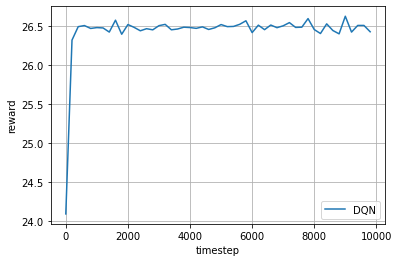

In [ ]:
logger.close_files()
logger.plot('DQN')

In [1]:
from google.colab import files
files.download('./experiments/blackjack_dqn_result/performance.csv') 

FileNotFoundError: ignored